# Simulation

In [13]:
%%capture
!pip install -r requirements.txt

In [14]:
from qutip import basis, tensor, sigmax, sigmay, sigmaz, concurrence, entropy_vn, partial_transpose, rand_ket
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
ket_0 = basis(2, 0) #|0>
ket_1 = basis(2, 1) #|1>

# Bell state phi_plus = (|00>+|11>)/sqrt(2)
phi_plus = (tensor(ket_0, ket_0) + tensor(ket_1, ket_1)).unit()
# Bell state phi_minus = (|00> - |11>)/sqrt(2)
phi_minus = (tensor(ket_0, ket_0) - tensor(ket_1, ket_1)).unit()
# Bell state psi_plus = (|01>+|10>)/sqrt(2)
psi_plus = (tensor(ket_0, ket_1) + tensor(ket_1, ket_0)).unit()
# Bell state psi_minus = (|01>-|10>)/sqrt(2)
psi_minus = (tensor(ket_0, ket_1) - tensor(ket_1, ket_0)).unit()

bell_states = {"phi_plus" : phi_plus, 
          "phi_minus": phi_minus, 
          "psi_plus": psi_plus, 
          "psi_minus": psi_minus}

In [16]:
def is_entangled_chsh(state):
    A_1 = sigmaz()
    A_2 = sigmax()
    B_1 = (sigmaz() + sigmax()) / np.sqrt(2)
    B_2 = (sigmaz() - sigmax()) / np.sqrt(2)
    CHSH_ZX = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmay()
    A_2 = sigmaz()
    B_1 = (sigmay() + sigmaz()) / np.sqrt(2)
    B_2 = (sigmay() - sigmaz()) / np.sqrt(2)
    CHSH_YZ = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmax()
    A_2 = sigmay()
    B_1 = (sigmax() + sigmay()) / np.sqrt(2)
    B_2 = (sigmax() - sigmay()) / np.sqrt(2)
    CHSH_XY = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    chsh_operators ={"CHSH_ZX": CHSH_ZX, "CHSH_YZ": CHSH_YZ, "CHSH_XY": CHSH_XY}

    for chsh_basis, chsh_operator in chsh_operators.items():
        violation = np.abs(state.dag() * chsh_operator * state)
        if violation > 2:
            return True
    return False

In [17]:
def is_entangled_concurrence(state):
    state_dm = state * state.dag() 
    conc = concurrence(state_dm)
    return conc != 0.0

In [18]:
def is_entangled_entropy(state):
    state_dm = state * state.dag() 
    ptrace = state_dm.ptrace(0) 
    entropy = entropy_vn(ptrace, base=2)
    return entropy != 0

In [19]:
def is_entangled_negativity(state):
    state_dm = state * state.dag()
    neg = (partial_transpose(state_dm, [0, 1]).eigenenergies() < 0).sum()
    return neg != 0

In [20]:
def get_simulated_training_data(entanglement_witness):
    samples_nb = 2000
    samples_states = []
    samples_is_entangled = []
    
    for _ in range(0, samples_nb):
        # Create an entangled state in the form: cos(theta)|00> + exp(i*phi)*sin(theta)|11>
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 0)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 1)))
        samples_states.append(state)
        samples_is_entangled.append(entanglement_witness(state))
    
        # Create an entangled state in the form: cos(theta)|01> + exp(i*phi)*sin(theta)|01>
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 1)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 0)))
        samples_states.append(state)
        samples_is_entangled.append(entanglement_witness(state))
    
        # Create a separable state |psi> X |phi>
        state = tensor(rand_ket(2), rand_ket(2))
        samples_states.append(state)
        samples_is_entangled.append(entanglement_witness(state))

    return samples_states, samples_is_entangled

In [21]:
def get_model(samples_states, samples_is_entangled):
    data = np.array([np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]) for state in samples_states])
    labels = np.array(samples_is_entangled)     

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data.shape[1],)),  # Adjust input shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    model.evaluate(X_val, y_val)

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model

MODEL FOR ENTANGLEMENT WITNESS CHSH
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7178 - loss: 0.5847 - val_accuracy: 0.7525 - val_loss: 0.4720
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.4350 - val_accuracy: 0.8425 - val_loss: 0.3529
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.3217 - val_accuracy: 0.8800 - val_loss: 0.2825
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8940 - loss: 0.2540 - val_accuracy: 0.9033 - val_loss: 0.2285
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9264 - loss: 0.1961 - val_accuracy: 0.9275 - val_loss: 0.1799
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9498 - loss: 0.1597 - val_accuracy: 0.9550 - val_loss: 0.1492
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1390 - val_accuracy: 0.9567 - val_loss: 0.1289
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.96

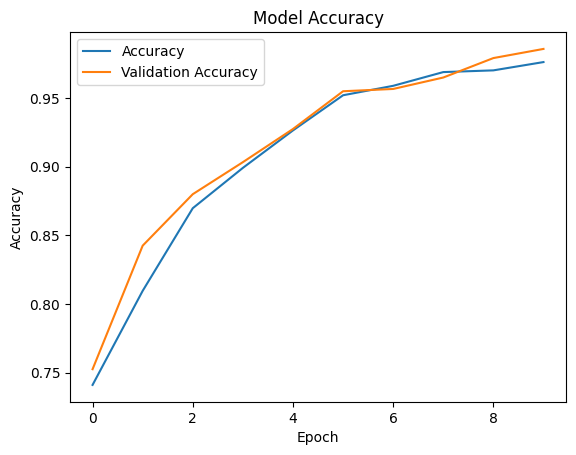

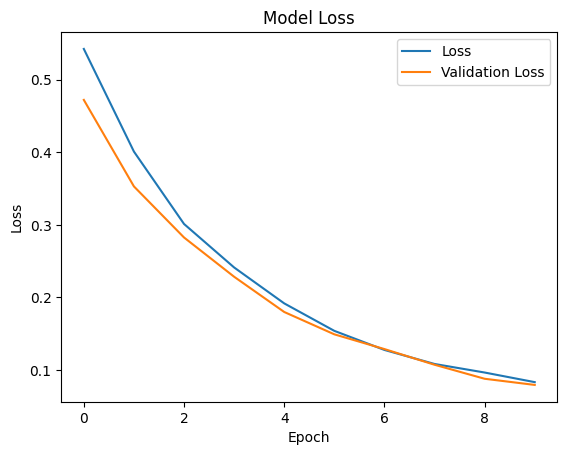

MODEL FOR ENTANGLEMENT WITNESS CONCURRENCE
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6628 - loss: 0.6089 - val_accuracy: 0.8625 - val_loss: 0.3726
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9038 - loss: 0.2809 - val_accuracy: 0.9408 - val_loss: 0.1607
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1399 - val_accuracy: 0.9517 - val_loss: 0.1189
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1100 - val_accuracy: 0.9725 - val_loss: 0.0910
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9748 - loss: 0.1008 - val_accuracy: 0.9817 - val_loss: 0.0816
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9768 - loss: 0.0922 - val_accuracy: 0.9800 - val_loss: 0.0746
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0785 - val_accuracy: 0.9808 - val_loss: 0.0669
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

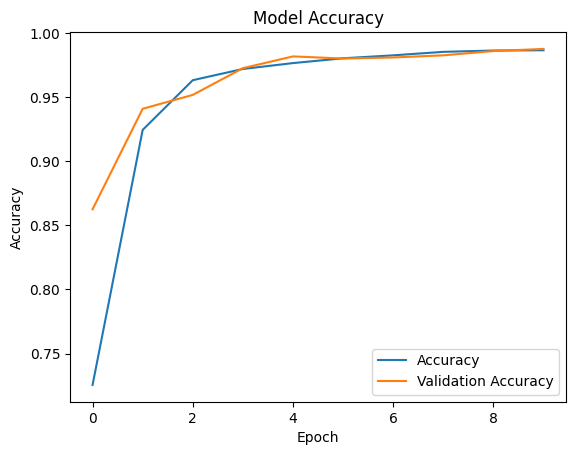

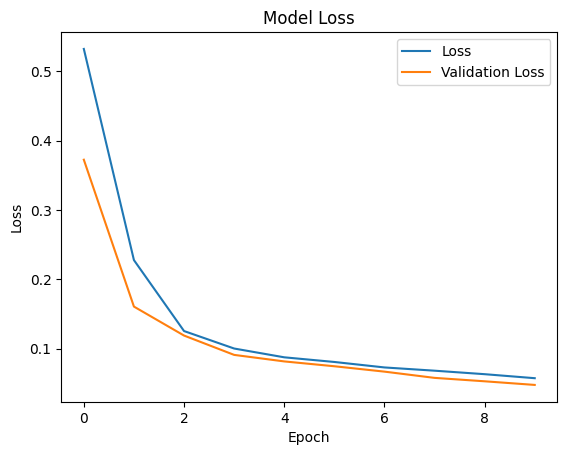

MODEL FOR ENTANGLEMENT WITNESS ENTROPY
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9785 - loss: 0.2824 - val_accuracy: 0.9867 - val_loss: 0.0689
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0778 - val_accuracy: 0.9867 - val_loss: 0.0680
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0615 - val_accuracy: 0.9867 - val_loss: 0.0673
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0725 - val_accuracy: 0.9867 - val_loss: 0.0679
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9844 - loss: 0.0768 - val_accuracy: 0.9867 - val_loss: 0.0675
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0744 - val_accuracy: 0.9867 - val_loss: 0.0667
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9887 - loss: 0.0562 - val_accuracy: 0.9867 - val_loss: 0.0667
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

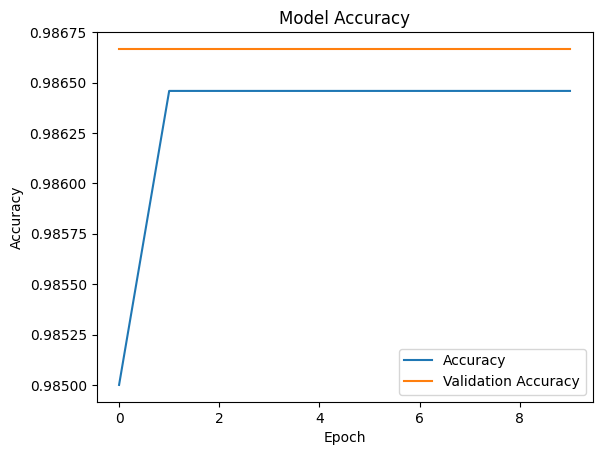

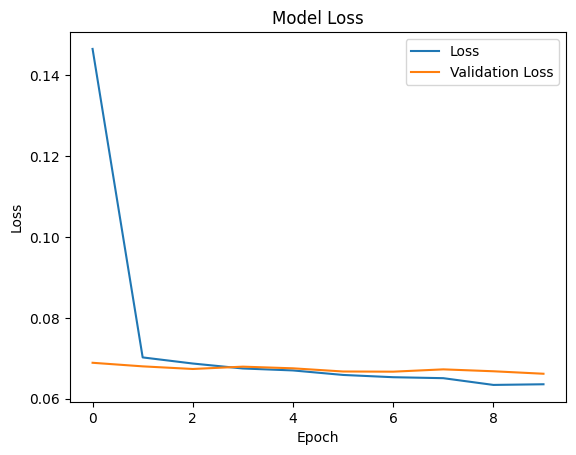

MODEL FOR ENTANGLEMENT WITNESS NEGATIVITY
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9675 - loss: 0.2825 - val_accuracy: 0.9992 - val_loss: 0.0094
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9979 - loss: 0.0151 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0106 - val_accuracy: 0.9992 - val_loss: 0.0079
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0174 - val_accuracy: 0.9992 - val_loss: 0.0071
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9971 - loss: 0.0178 - val_accuracy: 0.9992 - val_loss: 0.0072
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0150 - val_accuracy: 0.9992 - val_loss: 0.0072
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9975 - loss: 0.0154 - val_accuracy: 0.9992 - val_loss: 0.0069
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

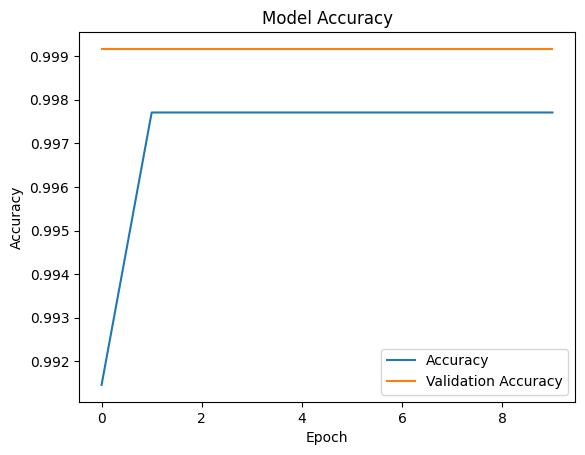

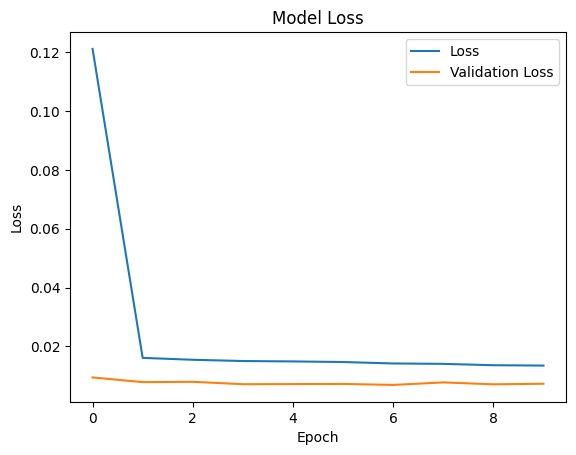

In [22]:
entanglement_witnesses = {"CHSH": is_entangled_chsh, "CONCURRENCE": is_entangled_concurrence, "ENTROPY": is_entangled_entropy, "NEGATIVITY": is_entangled_negativity}
models = {}

for name, witness in entanglement_witnesses.items():
    print("MODEL FOR ENTANGLEMENT WITNESS", name)
    samples_states, samples_is_entangled =  get_simulated_training_data(witness)
    model = get_model(samples_states, samples_is_entangled)
    models[name] = {"model": model, "witness": witness}


In [23]:
for name, model_data in models.items():
    model = model_data["model"]
    witness = model_data["witness"]
    
    print("TESTS FOR MODEL", name)
    
    for state_name, state in bell_states.items():
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state_name, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))
    
    for _ in range(0, 4):
        state = tensor(rand_ket(2), rand_ket(2))
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))

TESTS FOR MODEL CHSH
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted probability of phi_plus being entangled: 0.9974411725997925
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability of phi_minus being entangled: 0.995952844619751
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability of psi_plus being entangled: 0.9163147807121277
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted probability of psi_minus being entangled: 0.9997217059135437
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted probability of Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.18182348+0.55690883j]
 [-0.09003937+0.62167052j]
 [-0.34924349+0.00234097j]
 [-0.33675676-0.16379815j]] being entangled: 6.99152260201898e-15
Is the state entangled [is_entangled_chsh]:  F